In [13]:
import numpy as np
import math
import matplotlib.pyplot as plt

### 1 - Standardization
We suppose that the feature of u is u, that is the embedding is the identity.

Then 
$$
p = \frac{1}{N}U^T
\begin{bmatrix}
1\\ 1 \\ \dots \\1
\end{bmatrix}.
$$

It's the proportion of $j$-th entries that were $1$ over the total $m$, equivalently can be thought as the empirical mean of a Bernoulli.

To compute the standard deviation, we use exactly this interpretation, which in particular gives that the number of $1$'s is $p_jm$ and that of $0$'s is $(1-p_j) m$. Quindi,
$$
\sigma_j = \sqrt{\frac{1}{N-1} \sum^N_j \left(u_j^i - p_j\right)^2} = \sqrt{\frac{1}{N-1} (p_j^2 (1-p_j) N + (1-p_j)^2 p_j N)} = \sqrt{\frac{N}{N-1}p_j(1-p_j)}
$$
which is also the empirical std of a Bernoulli.

To find X, one removes the respective mean from each component, and row-multiplies
$$
X = \mathrm{diag}(\frac{1}{\sigma_1},\dots,\frac{1}{\sigma_n})(U-\mathrm{diag}(p_1,\dots,p_n)\mathrm{ones}(n,m)).
$$

note: idiots in ML want to see one as result of the z-scoring, so they use $N$ instead of $N-1$. This is simply bullshit.

In [14]:
n = 400
m = 40
U = np.random.randint(0,2,[n,m])

def standardize(U):
        [n,m] = np.shape(U)
        
        p = np.sum(U,axis=0)/n
        
        S = np.diag(np.ones(m)/np.sqrt(p*(1-p)))
        X = (U-np.ones([n,m]) @ np.diag(p)) @ S
        return X
        
        # # in case we do not want to use structure-specific code
        # S = np.diag(np.sqrt(p*(1-p)))
        # X = np.linalg.solve(S.T,(U-np.ones([n,m]) @ np.diag(p)).T)
        # return X.T

X = standardize(U)
print(np.max(np.mean(X,axis=0)))
print(np.max(np.std(X,axis=0)))

2.9531932455029166e-16
1.0000000000000027


### 2 - knn is just special weighted nn
They are $1/k$ for the $k$ nearest entries according to the norm. To obtain them, we have few ways:
- to sort the set of y's according to norm(x-x_i) and take the sum of first k entries
- to use np.argsort => returns indexes of sorted array
We implement the latter

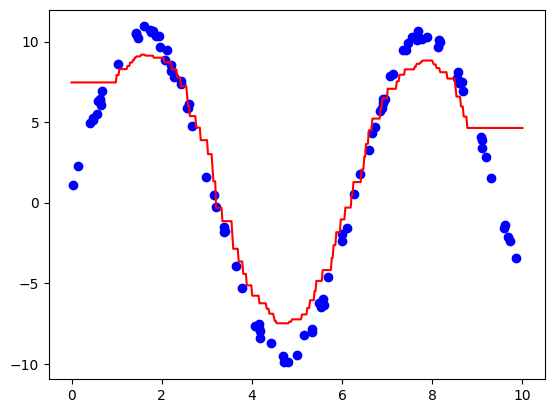

In [44]:
# parameters
n = 100
k = 20
X = 10*np.random.rand(n) # x is in R => specific syntax
Y = 10*np.sin(X) + np.random.rand(n) # y is in R

# show-off of argsort usage
xv = np.linspace(0,10,500)
yv = np.empty(500)
for i in range(500):
	indexed = np.argsort(np.abs(X-xv[i]))
	yv[i] = np.sum(Y[indexed[0:k]])/k

# visualization
plt.scatter(X,Y,color="blue")
plt.plot(xv,yv,color="red")
plt.show()

### 3 - Feature engineering not affecting results (due to predictor choice)
It does not sort any effect since when we compute the predictor both $x^i_1$ and $x_1$ are $1$, and so $x^i_1-x_1=0$, and so it does not contribute to the two-norm some, which we use in snn and knn.

### 4 - Ordered (cyclical) feature embedding
we get a torus. The idea is to map (d,h) on a plane, and then "connect" the extrema that are cyclic in their nature.

### 5 - Validation of different feature maps and predictors
Here is the code:

In [ ]:
import json
import random as rd

import numpy as np
import matplotlib.pyplot as plt

from ee104.hw2 import SoftNN, RMS

def import_json():
        with open('feat_valid.json','r') as file:
                data = json.load(file)
        U = np.array(data['U']['data'])
        v = np.array(data['v']['data'])
        return (U,v)

def partition_data(U,v,p): # p is the proportion of data devoted to test set
        [N,m] = np.shape(U)
        index = np.array(range(N))
        rd.shuffle(index)
        return(U[index > N*p],U[index <= N*p],v[index > N*p],v[index <= N*p])

def feature_map_1(U):
        return U
def feature_map_2(U):
        return np.concatenate([U,np.stack([U[:,0]*U[:,1],U[:,2]*U[:,1],U[:,2]*U[:,0]]).T,U**2],axis=1)

[U,v] = import_json()

[U, Ut, v, vt] = partition_data(U,v,.2)
[X1, X1t] = [feature_map_1(U),feature_map_1(Ut)]
[X2, X2t] = [feature_map_2(U),feature_map_2(Ut)]

R = np.linspace(.1,1.5,20);

RMStrain1 = np.empty(np.shape(R)); RMStest1 = np.empty(np.shape(R))
RMStrain2 = np.empty(np.shape(R)); RMStest2 = np.empty(np.shape(R))
for i in range(np.size(R)):
        RMStrain1[i] = RMS(SoftNN(X1,X1,v,R[i]),v)
        RMStest1[i] = RMS(SoftNN(X1t,X1,v,R[i]),vt)
        RMStrain2[i] = RMS(SoftNN(X2,X2,v,R[i]),v)
        RMStest2[i] = RMS(SoftNN(X2t,X2,v,R[i]),vt)

plt.plot(R,RMStrain1,color="blue",label="train - 1 feature map")
plt.plot(R,RMStest1,color="red",label="test - 1 feature map")
plt.plot(R,RMStrain2,color="green",label="train - 2 feature map")
plt.plot(R,RMStest2,color="purple",label="test - 2 feature map")
plt.legend()
plt.show()

# the result makes sense since the scale of the problem is 1, indeed.
# so, the second and first feature maps, with smoother parameters are best.

# at start strong underfit given by nearly piecewise approximation.
# at the end, it is nearly constant and stays so.